In [110]:
!pip install optuna
!pip install tqdm
!pip install feature-engine
!pip install scikit-learn
!pip install lightgbm
!pip install --upgrade scikit-learn
!pip install --upgrade <cyclical-features-library>


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The syntax of the command is incorrect.


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from feature_engine.creation import CyclicalFeatures
import warnings
warnings.filterwarnings('ignore')

In [112]:
#Loading the Data

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

Data Preprocessing
-> Clean the data by adding the mean value to the fields where it is missing or a random value where the mean can t be calculated
-> dropping the id column

In [113]:

mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)
test['Age'] = test['Age'].fillna(mean_age)

median_annual_income = train['Annual Income'].median()
train['Annual Income'] = train['Annual Income'].fillna(median_annual_income)
test['Annual Income'] = test['Annual Income'].fillna(median_annual_income)

train = train.dropna(subset=['Marital Status'])
test['Marital Status'] = test['Marital Status'].apply(
    lambda x: np.random.choice(['Single', 'Married', 'Divorced'],
                               p=[0.3347, 0.3337, 0.3316]) if pd.isna(x) else x
)

mean_number_dependents = train['Number of Dependents'].mean()
train['Number of Dependents'] = train['Number of Dependents'].fillna(mean_number_dependents)
test['Number of Dependents'] = test['Number of Dependents'].fillna(mean_number_dependents)

train['Occupation'] = train['Occupation'].fillna('Missing')
test['Occupation'] = test['Occupation'].fillna('Missing')

mean_health_score = train['Health Score'].mean()
train['Health Score'] = train['Health Score'].fillna(mean_health_score)
test['Health Score'] = test['Health Score'].fillna(mean_health_score)

data_vc_train = train.dropna(subset=['Vehicle Age'])
mean_vehicle_age = test['Vehicle Age'].mean()
test['Vehicle Age'] = test['Vehicle Age'].fillna(mean_vehicle_age)

mean_credit_score = train['Credit Score'].mean()
train['Credit Score'] = train['Credit Score'].fillna(mean_credit_score)
test['Credit Score'] = test['Credit Score'].fillna(mean_credit_score)

mean_insurance_duration = train['Insurance Duration'].mean()
train['Insurance Duration'] = train['Insurance Duration'].fillna(mean_insurance_duration)
test['Insurance Duration'] = test['Insurance Duration'].fillna(mean_insurance_duration)

train['Customer Feedback'] = train['Customer Feedback'].fillna('Unknown')
test['Customer Feedback'] = test['Customer Feedback'].fillna('Unknown')

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [114]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
train['Age'] = min_max_scaler.fit_transform(train[['Age']])
test['Age'] = min_max_scaler.fit_transform(test[['Age']])

In [115]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train['Annual Income'] = scaler.fit_transform(train[['Annual Income']])
test['Annual Income'] = scaler.transform(test[['Annual Income']])

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train['Health Score'] = scaler.fit_transform(train[['Health Score']])
test['Health Score'] = scaler.transform(test[['Health Score']])

In [117]:
Q1 = train['Previous Claims'].quantile(0.25)
Q3 = train['Previous Claims'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
train = train[(train['Previous Claims'] >= lower_bound) & (train['Previous Claims'] <= upper_bound)]

proportions = {
    0.0: 0.365706,
    1.0: 0.360090,
    2.0: 0.200233,
    3.0: 0.058445,
    4.0: 0.012677,
    5.0: 0.002410,
    6.0: 0.000358,
    7.0: 0.000070,
    8.0: 0.000010,
    9.0: 0.000001
}

# Oranları normalize ediyoruz (toplamları 1 olmalı, fakat zaten uygun görünüyor)
categories = list(proportions.keys())
probabilities = list(proportions.values())

# Eksik değerleri rastgele dolduruyoruz
train['Previous Claims'] = train['Previous Claims'].apply(
    lambda x: np.random.choice(categories, p=probabilities) if pd.isna(x) else x
)

# Eksik değerleri rastgele dolduruyoruz
test['Previous Claims'] = test['Previous Claims'].apply(
    lambda x: np.random.choice(categories, p=probabilities) if pd.isna(x) else x
)

In [118]:
#Cycling dates
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])

# Cyclical encoding of the year - no need for cos and sinus interpretations
train['Year'] = train['Policy Start Date'].dt.year
test['Year'] = test['Policy Start Date'].dt.year

train['Month'] = train['Policy Start Date'].dt.month
test['Month'] = test['Policy Start Date'].dt.month

train['Month_cos'] = np.cos(2 * np.pi * train['Month'] / 12)
train['Month_sin'] = np.sin(2 * np.pi * train['Month'] / 12)

test['Month_cos'] = np.cos(2 * np.pi * test['Month'] / 12)
test['Month_sin'] = np.sin(2 * np.pi * test['Month'] / 12)

train['Day'] = train['Policy Start Date'].dt.day
test['Day'] = test['Policy Start Date'].dt.day

train['Day_cos'] = np.cos(2 * np.pi * train['Day'] / 30)
train['Day_sin'] = np.sin(2 * np.pi * train['Day'] / 30)

test['Day_cos'] = np.cos(2 * np.pi * test['Day'] / 30)
test['Day_sin'] = np.sin(2 * np.pi * test['Day'] / 30)

train['Group'] = (train['Year'] - 2020) * 48 + train['Month'] * 4 + train['Day'] // 7
test['Group'] = (test['Year'] - 2020) * 48 + test['Month'] * 4 + test['Day'] // 7

train.drop(columns=['Day','Month','Policy Start Date'], inplace=True)
test.drop(columns=['Day','Month','Policy Start Date' ], inplace=True)

In [119]:
Q1 = train['Premium Amount'].quantile(0.25)  # Calculate the first quartile (25th percentile) of the 'price' column
Q3 = train['Premium Amount'].quantile(0.75)  # Calculate the third quartile (75th percentile) of the 'price' column
IQR = Q3 - Q1  # Calculate the interquartile range (IQR) for 'price'

# Define the boundaries to consider a value as an outlier
lower_bound = Q1 - 1.5 * IQR  # Calculate the lower bound (below which values will be considered outliers)
upper_bound = Q3 + 1.5 * IQR  # Calculate the upper bound (above which values will be considered outliers)

# Filter out the outliers from the 'price' column
train_df = train[(train['Premium Amount'] >= lower_bound) & (train['Premium Amount'] <= upper_bound)]  # Keep only the data points within the bounds
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Year,Month_cos,Month_sin,Day_cos,Day_sin,Group
0,0.021739,Female,-0.393594,Married,1.0,Bachelor's,Self-Employed,-0.254751,Urban,Premium,...,No,Weekly,House,2869.0,2023,1.000000e+00,-2.449294e-16,0.104528,-9.945219e-01,195
1,0.456522,Female,0.220534,Divorced,3.0,Master's,Missing,-0.849660,Rural,Comprehensive,...,Yes,Monthly,House,1483.0,2023,-1.000000e+00,1.224647e-16,-0.809017,5.877853e-01,169
2,0.108696,Male,0.048014,Divorced,3.0,High School,Self-Employed,1.825498,Suburban,Premium,...,Yes,Weekly,House,567.0,2023,-1.836970e-16,-1.000000e+00,1.000000,-1.133108e-15,184
3,0.065217,Male,3.348874,Married,2.0,Bachelor's,Missing,-1.241659,Rural,Basic,...,Yes,Daily,Apartment,765.0,2024,-1.000000e+00,1.224647e-16,-0.809017,5.877853e-01,217
4,0.065217,Male,0.446918,Single,1.0,Bachelor's,Self-Employed,-0.442869,Rural,Premium,...,Yes,Weekly,House,2022.0,2021,1.000000e+00,-2.449294e-16,0.978148,2.079117e-01,96


In [120]:
#encoding the categorical columns
le = LabelEncoder()

for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

In [121]:
from sklearn.model_selection import train_test_split

y = train['Premium Amount']
X = train.drop(columns=['Premium Amount'])

X_train, X_ref, y_train, y_ref = train_test_split(X, y, test_size=0.2, random_state=42)


In [122]:
def rmsLe(y_true, y_pred):
    y_pred = np.maximum(y_pred, 1e-6)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# SEED = 42
# n_splits = 5

# def TrainML(params, e_stop=50):
#     kfold = RepeatedKFold(n_splits=n_splits, n_repeats=1, random_state=SEED)
#     train_rmse_scores = []
#     val_rmse_scores = []

#     for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(X, y), desc="Training Folds", total=n_splits)):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         y_train_log = np.log1p(y_train)
#         y_val_log = np.log1p(y_val)
        
#         callbacks = [lgb.early_stopping(stopping_rounds=e_stop, verbose=False)]
#         model = lgb.LGBMRegressor(**params, random_state=SEED, verbose=-1, n_jobs=-1)
#         model.fit(X_train, y_train_log, 
#                   eval_set=[(X_val, y_val_log)], 
#                   eval_metric='rmse', 
#                   callbacks=callbacks)
        
#         y_train_log_pred = model.predict(X_train)
#         y_val_log_pred = model.predict(X_val)
        
#         y_train_pred = np.expm1(y_train_log_pred)
#         y_val_pred = np.expm1(y_val_log_pred)
        
#         train_rmse = rmsLe(y_train, y_train_pred)
#         val_rmse = rmsLe(y_val, y_val_pred)

#         train_rmse_scores.append(train_rmse)
#         val_rmse_scores.append(val_rmse)

#     mean_train_rmse = np.mean(train_rmse_scores)
#     mean_val_rmse = np.mean(val_rmse_scores)

#     print("\n Final Mean Scores:")
#     print(f" Mean Train RMSLE: {mean_train_rmse:.4f}")
#     print(f" Mean Validation RMSLE: {mean_val_rmse:.4f}")

#     return mean_train_rmse, mean_val_rmse

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
#         'device': 'gpu'
#     }

#     mean_train_rmse, mean_val_rmse = TrainML(params)
#     trial.set_user_attr('train_rmse', mean_train_rmse)
#     trial.set_user_attr('val_rmse', mean_val_rmse)
#     return mean_val_rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=5)


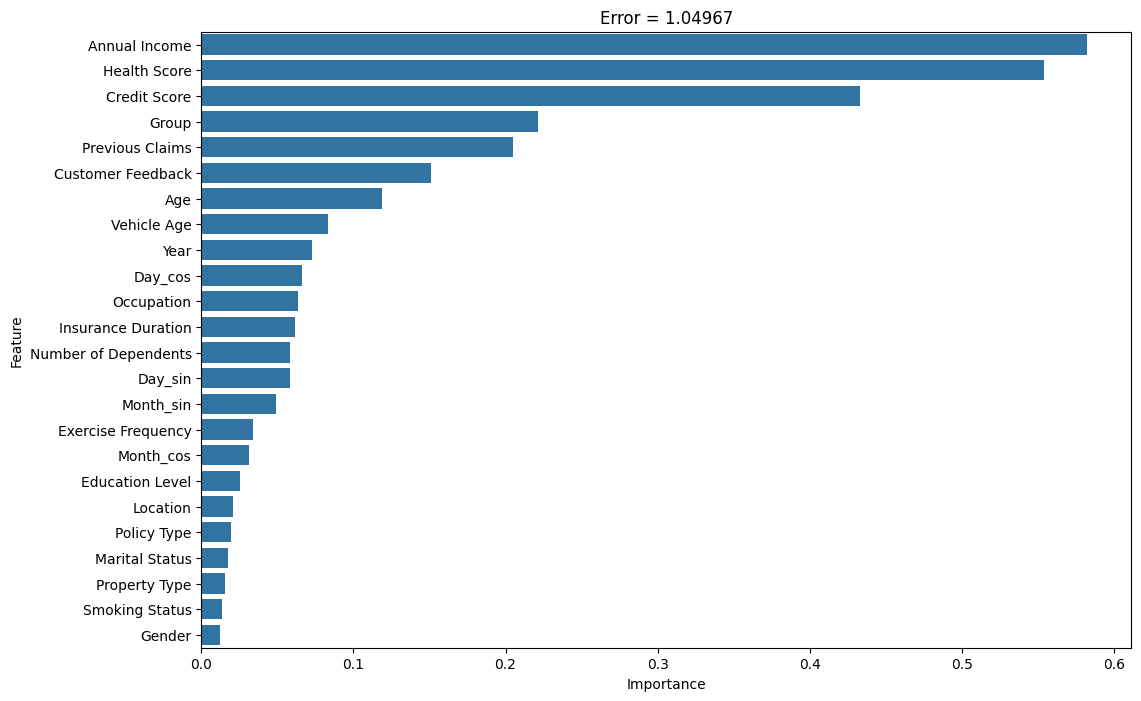

In [123]:
best_params = {'n_estimators': 700, 'learning_rate': 0.006002641114390338, 'num_leaves': 42, 'max_depth': 15, 'min_child_samples': 72, 
               'subsample': 0.7200344333898133, 'colsample_bytree': 0.6986521753741868, 'reg_alpha': 0.0013223748424590466, 
               'reg_lambda': 0.40630468090624405}

#Training LGBMRegressor Model - It is known for being fast and efficient in training, especially on large datasets.
best_model = LGBMRegressor(**best_params, verbose=-1, n_jobs=-1)
best_model.fit(X_train, np.log1p(y_train))#this log is recommended when the distribution is skewed

#Make predictions
test_preds = best_model.predict(X_ref)
test_preds = np.expm1(test_preds)

error_lgbm = rmsLe(y_ref, test_preds)

# sample_submission['Premium Amount'] = test_preds
# sample_submission.to_csv('submission1.csv', index=False)

#Visualising the importance of each field of the dataset in determing the Premium Amount
importances = best_model.feature_importances_
norm_importances = importances / np.linalg.norm(importances)
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': norm_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Error = {:.5f}'.format(error_lgbm))
plt.show()